# Segmentez des clients d'un site e-commerce - Partie(1/3): Exploration

## Description: 

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.
Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

## Objectif:

- Comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles

- Fournir à Olist, une segmentation de ses clients avec une description actionable de cette segmantation et sa logique sous-jacente

- Fournir à Olist, une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temp

# <font color="#1d479b">Sommaire</font>

1. [Chargements des données et observations](#partie1)
  * 1.1. [Définitions des fonctions utiles pour l'observation des données](#partie1_1)
  * 1.2. [Vue générale des données brutes](#partie1_2)
  * 1.3. [Concaténation des données](#partie1_2)
2.  [Nettoyage des données](#partie2)
   *  2.1 [Suppression des données manquantes et les lignes dupliquées](#partie2_1)
   *  2.2 [Variables d'interêts à garder](#partie2_2)
3. [Analyse Exploratoire des données](#partie3)
  *  3.1. [Analyse univariée](#partie3_1)
4. [Segmentation RFM](#partie4)
   * 4.1 [Création de la fonction permettant de calculer la RFM](#partie4_1)
   * 4.2 [Analyse exploratoire sur la RFM ](#partie4_2)

# 1.Chargement des données et observations <a class="anchor" id="partie1"></a>

In [1]:
#Importation des librairies nécessaires à l'étude du projet 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#Chargement des données brutes

customers = pd.read_csv('Data/olist_customers_dataset.csv')
geolocalisation = pd.read_csv('Data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('Data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('Data/olist_orders_dataset.csv')
products = pd.read_csv('Data/olist_products_dataset.csv')
sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
product_category = pd.read_csv('Data/product_category_name_translation.csv')

### 1.1/Définitions des fonctions utiles pour l'observation des données <a class="anchor" id="partie1_1"></a>

In [4]:
def nb_cells(data):
    #Fonction qui prend en entrée une dataFrame et renvoie le nombre de cellules au total
    return data.size

def nb_lines(data):
    #Fonction qui prend en entrée une dataFrame et renvoie le nombre de lignes
    return len(data)

def nb_columns(data):
    #Fonction qui prend en entrée une dataFrame et renvoie le nombre de colonnes
    return len(data.columns)

def missing_cells(data):
    #Fonction qui prend en entrée une dataFrame et renvoie le nbre cellule manquante total
    #return data.isna().sum()# Ici on calcul le nomre de cellules manquantes en fonction de chaque colonne
    return data.isna().sum().sum()

def missing_cells_percent(data):
    #Fonction qui prend en entrée une dataFrame et renvoie le % de cellule manquante
    return data.isna().sum().sum()/(data.size)

def count_duplicates_rows(data):
    #Fonction qui prend en entrée une dataFrame et renvoie le nbre de ligne dupliquée
    return len(data)-len(data.drop_duplicates())

def count_duplicates_rows_percent(data):
   #Fonction qui prend en entrée une dataFrame et renvoie le % de ligne dupliquée
    return count_duplicates_rows(data)/nb_lines(data)

def count_data_type(data):
   #Fonction qui prend en entrée une dataFrame et renvoie le % de ligne dupliquée
    return data.dtypes.value_counts()

def namestr(obj, namespace):
    #Fonction qui renvoie le nom d'une variable dans l'espace namespace
    return [name for name in namespace if namespace[name] is obj]


def vue_generale_data(data):    
    #Fonction qui prend un dataFrame et qui renvoie certaines de ses caractéristiques: nombres de variables, 
    #nombres de cellules, cellules manquantes, etc...

    print('--------------------------------------------------------------------------')
    print('Donnée : {}'.format(namestr(data, globals())))
    print('Nombre de variable : {}'.format(nb_columns(data)))
    print('Nomres de types de variables : {}'.format(count_data_type(data)))
    print('Nombre observation : {}'.format(nb_lines(data)))
    print('Nombre de cellules manquantes : {}'.format(missing_cells(data)))
    print('% de cellules manquantes : {:.2%}'.format(missing_cells_percent(data)))
    print('Nombre de lignes dupliquées : {}'.format(count_duplicates_rows(data)))
    print('% de lignes dupliquées : {:.2%}'.format(count_duplicates_rows_percent(data)))
    
    return None

def vue_general_variable(data):
    #Fonction qui prend en entrée un dataFrame et qui fait un résumé des Variables de cette dataFrame: le nom,
    #le type, etc...
        
    print('--------------------------------------------------------------------------')
    print('Nom de la Donnée : {}'.format(namestr(data, globals())))
    print('--------------------------------------------------------------------------')
    df = pd.DataFrame(columns=['Nom variable','Type de la variable','nbre observation','Valeurs manquantes','% Valeurs manquantes', 'Moyenne', 'Mediane','Variance','Stdev' ,'min','25%','50%','75%','max'])
    for column in data.columns:
        type_var = data[column].dtypes
        nombre_obs = len(data[column].unique())     
        val_manquantes = missing_cells(data[column])
        perc_val_manquantes = missing_cells_percent(data[column])
        if type_var != 'object':       
            df = df.append(pd.DataFrame([[column,type_var,nombre_obs,val_manquantes,perc_val_manquantes,data[column].mean(),data[column].median(),data[column].var(ddof=0),
                                          data[column].std(ddof=0),data[column].min(),data[column].quantile(0.25),data[column].quantile(0.5),data[column].quantile(0.75),data[column].max()]], columns=['Nom variable','Type de la variable','nbre observation','Valeurs manquantes','% Valeurs manquantes', 'Moyenne', 'Mediane','Variance','Stdev' ,'min','25%','50%','75%','max']))
        else:            
            df = df.append(pd.DataFrame([[column,type_var,nombre_obs,val_manquantes,perc_val_manquantes,'','','','','','',''
                                    ,'','']], columns=['Nom variable','Type de la variable','nbre observation','Valeurs manquantes','% Valeurs manquantes', 'Moyenne', 'Mediane','Variance','Stdev' ,'min','25%','50%','75%','max']))
               
    return df

def plot_NA(data: pd.DataFrame):
    # Fonction qui prend en entrée un dataFrame et qui affiche en histogramme les pourcentages des valeurs manquantes
    columns_emptiness = pd.DataFrame({
        col : { 
            'count': data[col].isna().sum(),
            'percent': 100 * data[col].isna().sum() / data.shape[0],
        } for col in data.columns
                                    }).transpose()
    fig = px.bar(columns_emptiness,
        color='count',
        y='percent',
        hover_data=['count'],
        title='NA per column',
        width=1000,
        height=700)
    fig.show()
    
def Sup_Variable_perc(df , perc): 
    #Fonction qui prend en entrée une dataFrame et une valeur seuil (en % etre 0 et 1) et qui supprime toutes les variables ayant plus de 1-perc % de valeurs manquantes 
    return df[df.columns[df.isna().sum()/df.shape[0] < perc]]
    #return df[df.isnull().sum(1)* 100 / len(df.columns) < perc]


def IQR_filter(s: pd.DataFrame, col_num: list, replace=np.nan):
  #Méthode interquartile en supprimant les données inf à Q1-1.5*IQR et sup à Q3+1.5*IQR
    for col in col_num:
        Q1 = s[col].quantile(0.25)
        Q3 = s[col].quantile(0.75)
        IQR = Q3-Q1
        s.loc[:,col] = s[col].where((s[col] > (Q1 - 1.5 * IQR)) & (s[col] < (Q3 + 1.5 * IQR)))  
    return(s)

def delete_NA(data: pd.DataFrame, Nutritive_colunms, perc=80):
    #Supprime les lignes ou colonnes vides 
    data = data.dropna(axis = 0, how = 'all')
    data = data.dropna(axis = 1, how = 'all')
    #Supprime les lignes ou colonnes avec 80% de valeurs manquantes 
    min_count = int(((100-perc)/100)*data.shape[1] + 1)
    min_count2 = int(((100-perc)/100)*data.shape[0] + 1)
    data = data.dropna(axis=0, thresh=min_count)
    data = data.dropna(axis=1, thresh=min_count2)
    return(data)

def KNN(data):
    #Méthode k-nn permettant d'imputer les valeurs manquantes
    cat = list(['created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'categories_fr',
       'countries_fr', 'nutrition_grade_fr', 
       'states', 'states_tags', 'states_fr',
       'main_category_fr'])
    dataKNN = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(data.filter(regex='_100g')),
                           columns = data.filter(regex='_100g').columns)
    data = pd.concat([data[cat].reset_index(drop=True), dataKNN.reset_index(drop = True)], axis=1)
    return(data)

### 1.2. Vue générale des données brutes <a class="anchor" id="partie1_2"></a>

#### a/ Info générale de chaque donnée

- Pour chaque donnée, nous allons l'afficher ainsi que quelques infos la concernant.

In [5]:
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [6]:
geolocalisation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [7]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [8]:
order_payments

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [9]:
order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [10]:
orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [11]:
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [12]:
sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [14]:
product_category

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


#### b/ Info générale de l'ensemble des données

In [15]:
# Création d'une liste regroupant toutes les données
liste_df = [customers, geolocalisation,order_items,order_payments,order_reviews,orders,products,sellers, product_category]
noms_df = ['customers','geolocalisation','order_items','order_payments','order_reviews','orders','products','sellers','product_category']

In [16]:
# Informations groupées: Dimensions, nombres de varaibles, ....
# Instanciation d'un dataframe pour mettre toutes les infos de chaque data
InfoGénérales = pd.DataFrame({})

for data in liste_df:
        InfoGénérales = InfoGénérales.append(pd.DataFrame({
            'Données' : [namestr(data, globals())],
            'Dimension' : [data.shape],
            'Nombre de variables' : [nb_columns(data)],
            'Nombre observations' :   [nb_lines(data)],
            'Nombres de types de variables' : [count_data_type(data)],
            'Nombre de cellules manquantes' :  [missing_cells(data)],
            '% de cellules manquantes' :  [missing_cells_percent(data)],
            'Nombre de lignes dupliquées' :  [count_duplicates_rows(data)],
            '% de lignes dupliquées' :  [count_duplicates_rows_percent(data)]
            
        }), ignore_index=True)

In [17]:
InfoGénérales

,Données,Dimension,Nombre de variables,Nombre observations,Nombres de types de variables,Nombre de cellules manquantes,% de cellules manquantes,Nombre de lignes dupliquées,% de lignes dupliquées
0,"[customers, _5, data]","(99441, 5)",5,99441,object 4 int64 1 dtype: int64,0,0.000000,0,0.000000
1,"[geolocalisation, _6, data]","(1000163, 5)",5,1000163,float64 2 object 2 int64 1 dtype: ...,0,0.000000,261831,0.261788
2,"[order_items, _7, data]","(112650, 7)",7,112650,object 4 float64 2 int64 1 dtype: ...,0,0.000000,0,0.000000
3,"[order_payments, _8, data]","(103886, 5)",5,103886,int64 2 object 2 float64 1 dtype: ...,0,0.000000,0,0.000000
4,"[order_reviews, _9, data]","(99224, 7)",7,99224,object 6 int64 1 dtype: int64,145903,0.210063,0,0.000000
5,"[orders, _10, data]","(99441, 8)",8,99441,object 8 dtype: int64,4908,0.006169,0,0.000000
6,"[products, _11, data]","(32951, 9)",9,32951,float64 7 object 2 dtype: int64,2448,0.008255,0,0.000000
7,"[___, sellers, _12, data]","(3095, 4)",4,3095,object 3 int64 1 dtype: int64,0,0.000000,0,0.000000
8,"[_, __, product_category, _13, _14, data]","(71, 2)",2,71,object 2 dtype: int64,0,0.000000,0,0.000000


**On a des NaN uniquement dans les données suivantes : order_reviews, orders et products**
- Regardons ce qu'il y a dans ces datas

In [18]:
# Regardons d'abord dans order_reviews
order_reviews.isna().sum(axis=0) 

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

**Pour order_reviews, les NaN correspondent à des commentaires vides**

In [19]:
#Regardons dans la data orders
orders.isna().sum(axis=0) 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

**Pour les orders, les NaN sont croissants dans l'ordre d'un processus de commande et correspondent aux commandes qui posent problème**

In [20]:
# Regardons dans la data proucts
products.isna().sum(axis=0)

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

**On a des produits pour lesquels il manque des informations importantes (en particulier la catégorie de produit).**

### 1.3 Concaténation des données 

In [21]:
df_1 = pd.merge(customers,orders,on="customer_id")
df_2 = pd.merge(df_1,order_items,on="order_id")
df_3 = pd.merge(df_2,products,on="product_id")
df_4 = pd.merge(df_3,order_reviews,on="order_id")
df_5 = pd.merge(df_4,order_payments,on="order_id")
df_6 = pd.merge(df_5,sellers,on="seller_id")

# 2 Nettoyages des données <a class="anchor" id="partie2"></a>

 ### 2.1 Variables d'interêts à garder<a class="anchor" id="partie2_1"></a>

<AxesSubplot:title={'center':'Proportion de NaN par variable (%)'}>

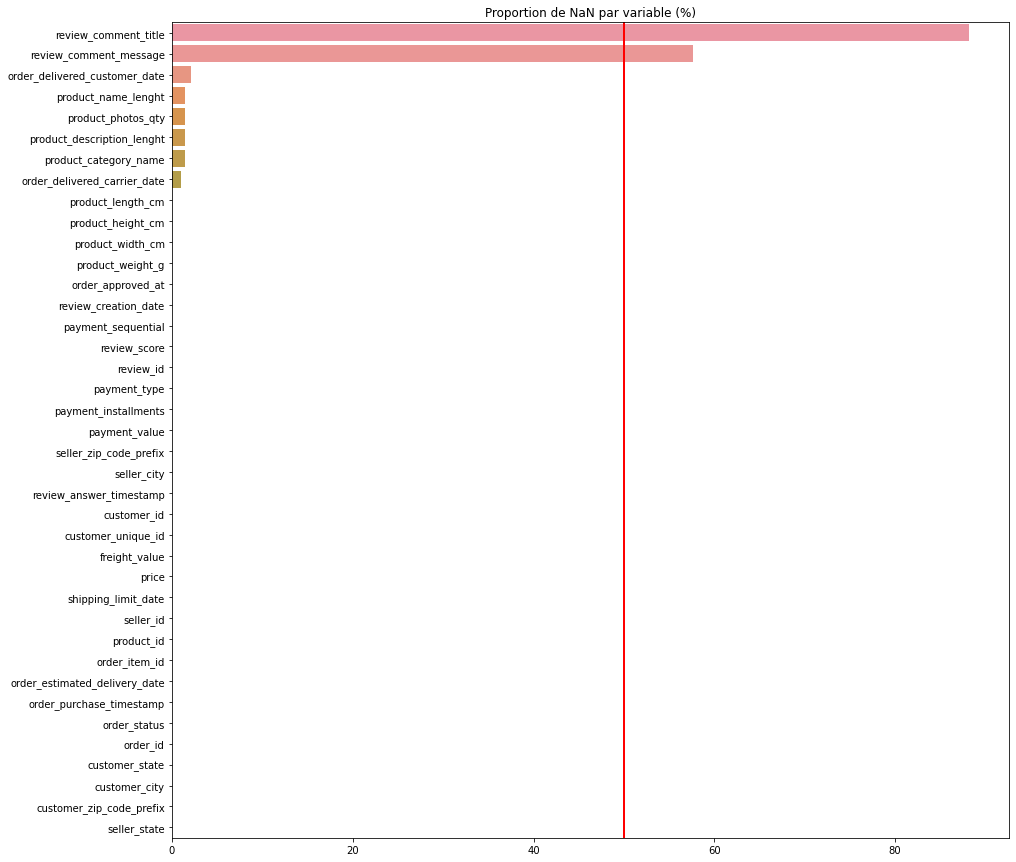

In [22]:
# Observation de la proportion de NaN par varaibles AVANT suppréssions des valeurs manquantes
data_nan = df_6.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(15,15))
sup_threshold = 50
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
#plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables ?', fontsize = 16, color = 'r') 
plt.title('Proportion de NaN par variable (%)')
sns.barplot(x=data_nan.values/df_6.shape[0]*100, y=data_nan.index)

#### FIltre 1: Nous allons garder que quelques variables qui nous interessent pour notre études

In [23]:
df = df_6[["customer_id","customer_unique_id","customer_city","customer_state","order_id","order_item_id","order_status","product_id","seller_id","seller_city","seller_state","order_approved_at","price","freight_value","product_category_name","review_id","review_score","payment_type","payment_installments","payment_value","seller_city"]]

<AxesSubplot:title={'center':'Proportion de NaN par variable (%)'}>

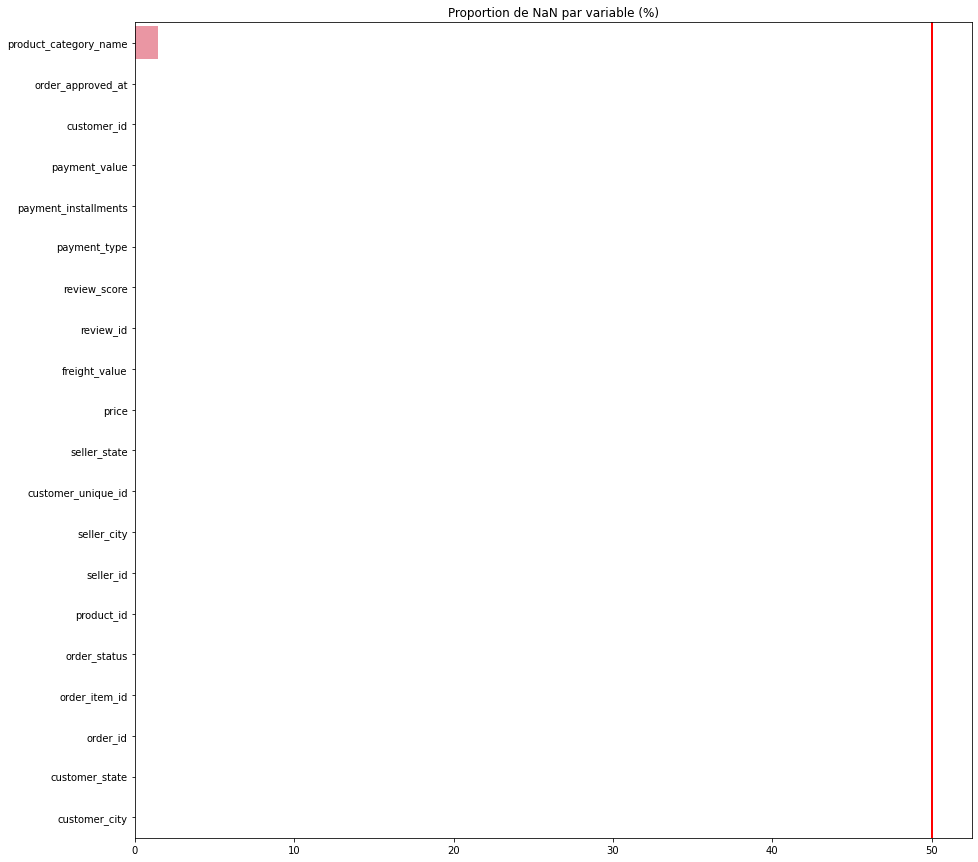

In [24]:
# Observation de la proportion de NaN par varaibles APRES suppréssions des valeurs manquantes
data_nan = df.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(15,15))
sup_threshold = 50
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
#plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables ?', fontsize = 16, color = 'r') 
plt.title('Proportion de NaN par variable (%)')
sns.barplot(x=data_nan.values/df.shape[0]*100, y=data_nan.index)

**Nous remarquons qu'il n y a presque pas de données manquantes à part quelques obervations manquantes sur la varaibles product_category_name: elles seront donc supprimer**


### 2.2 Suppression des données manquantes et les lignes dupliquées <a class="anchor" id="partie2_2"></a>

In [25]:
df_final = df.dropna()# Suppresion des données manquantes
df_final.shape

(115620, 21)

In [26]:
df_final = df_final.drop_duplicates(subset="customer_id")# Suppresion des lignes duppliquées
df_final.shape# Pas de lignes duppliqées

(96524, 21)

# 3.Analyse exploratoire <a class="anchor" id="partie3"></a>

## 3.1 Analyse univariée <a class="anchor" id="partie3_1"></a>

### 3.1.1. Sur les données de localisations au Brésil

In [27]:
# Le point au Brésil qui est le plus au Nord est à 5 deg 16′ 27.8″ N latitude
geolocalisation = geolocalisation[geolocalisation.geolocation_lat <= 5.27438888]
# # Le point au Brésil qui est le plus à l'Ouest est à 73 deg, 58′ 58.19″W Long
geolocalisation = geolocalisation[geolocalisation.geolocation_lng >= -73.98283055]
# # Le point au Brésil qui est le plus au Sud est à 33 deg, 45′ 04.21″ S Latitude
geolocalisation = geolocalisation[geolocalisation.geolocation_lat >= -33.75116944]
# Le point au Brésil qui est le plus à l'Est est à 34 deg, 47′ 35.33″ W Long.
geolocalisation = geolocalisation[geolocalisation.geolocation_lng <= -34.79314722]

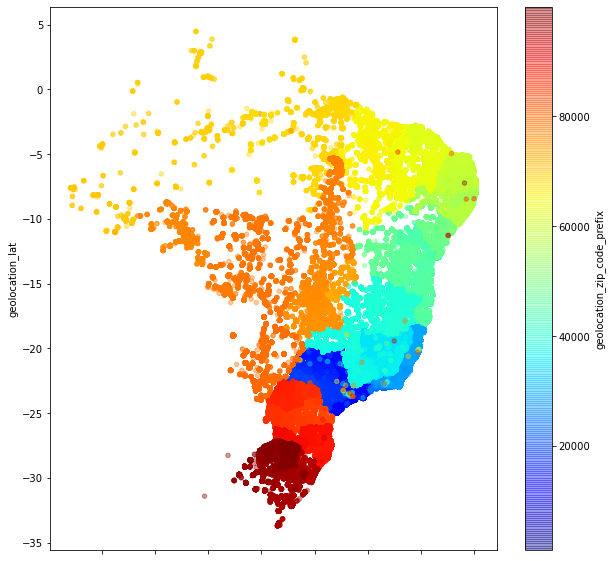

In [28]:
# Affichage des points de localisations des différents achats
geolocalisation.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat",
         alpha=0.4, c="geolocation_zip_code_prefix",
         cmap=plt.get_cmap("jet"), colorbar=True, figsize=(10, 10))
plt.show()

### 3.1.2. Sur les données (items_orders)

#### Quelques informations

- order_item_id est le nombre d'objets dans une même commande
- freight_value est le coût de livraison
- shipping_limit_date correspond à la date d'expédition auprès du transporteur
    
    

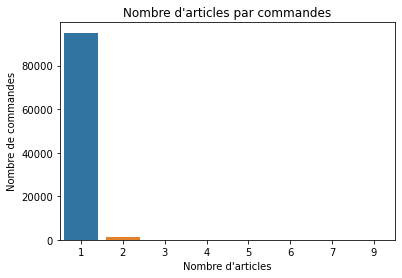

In [30]:
# Nombre d'articles dans une même commande
x = list(df_final["order_item_id"].value_counts().index)
y = df_final["order_item_id"].value_counts().values

plt.title("Nombre d'articles par commandes")
plt.xlabel("Nombre d'articles")
plt.ylabel("Nombre de commandes")
sns.barplot(x, y)
plt.show()

**La plus grande majorité de commandes comporte un seul article**

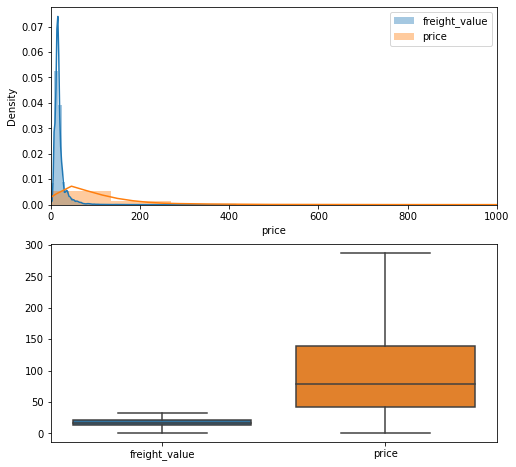

In [31]:
# Affichage du coût de transport des marchandises
fig = plt.figure(1, figsize=(8, 8))

# Histogramme freight value et prix
plt.subplot(211)
sns.distplot(df_final["freight_value"], label="freight_value")
sns.distplot(df_final["price"], label="price")
plt.legend()
# x-axis limits
plt.xlim([0, 1000])

# Boxplot freight value et prix
plt.subplot(212)
sns.boxplot(data=df_final, order=["freight_value", "price"], showfliers=False)
plt.show()

### 3.1.3. Données sur les vendeurs

In [32]:
# Nombre de villes
Number_of_cities = df_final["seller_city"].nunique()
# Nombre d'Etats
Number_of_states = df_final["seller_state"].nunique()
print("Le nombre de villes est : {}".format(Number_of_cities))
print("Le nombre d'états est : {}".format(Number_of_states))

Le nombre de villes est : seller_city    604
seller_city    604
dtype: int64
Le nombre d'états est : 23


In [33]:
df_final

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_item_id,order_status,product_id,seller_id,seller_city,seller_state,order_approved_at,price,freight_value,product_category_name,review_id,review_score,payment_type,payment_installments,payment_value,seller_city
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-05-16 15:22:12,124.99,21.88,moveis_escritorio,88b8b52d46df026a9d1ad2136a59b30b,4,credit_card,2,146.87,itaquaquecetuba
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-11-10 00:47:48,112.99,24.90,moveis_escritorio,7fc63200f12eebb5f387856afdd63db8,1,credit_card,1,275.79,itaquaquecetuba
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-05-08 22:22:56,124.99,15.62,moveis_escritorio,251191809e37c1cffc16865947c18a4d,3,credit_card,7,140.61,itaquaquecetuba
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,mage,RJ,2e604b3614664aa66867856dba7e61b7,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2018-02-04 22:29:19,106.99,30.59,moveis_escritorio,f7123bac5b91a0e2e38d8b41fd1206f4,4,credit_card,10,137.58,itaquaquecetuba
5,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,angelina,SC,574fe1739f65af76badd0999db300b4f,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-03-23 15:25:11,126.99,15.06,moveis_escritorio,1496c2a9c41a846ba946a98a09879660,4,credit_card,5,142.05,itaquaquecetuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117323,d21101a81657215bf9d86ccc3da340a1,9ba58a98da1d0abf0bd1e422e06c9051,sao manuel,SP,d35703faec55cda0ceeb4f50a4d584ae,1,canceled,4444290d1f0ec9579d5b21dc589251c0,4ce6e5f6c52515177e18c1c9361d8677,sao bernardo do campo,SP,2018-07-16 22:20:45,226.60,25.67,automotivo,2bb20c7f19a9aa625bd8e6ba9f000f27,3,credit_card,5,252.27,sao bernardo do campo
117324,eda10d7eb51a675d000956fa1aabc7dd,5c22dbb9d8b5385953f2f1e6d9d115a7,jordania,MG,b494f624c631105b24fe497277085909,1,delivered,a2fce4213a6ac271129618259a334261,9140ef75cc8211c4035935e80e567204,maringa,PR,2018-08-02 18:50:15,49.90,22.28,pet_shop,709ee020ff826ee5289d7dd5d6911d0c,5,credit_card,3,72.18,maringa
117325,f0f671d4034e98cdf20f0c452d6db02b,6532316a8c1a7c7a569482db073530bb,guarulhos,SP,f73b31435ce6dec43df056154c39a1ce,1,shipped,5ece1e51ece4648de249ec6e9d007fd6,da4d149c0ddbac90557103ac0a0ec356,sbc,SP,2018-08-20 15:35:42,730.00,45.98,casa_construcao,274e38de8990f74fc03894fa488b5cd5,3,credit_card,10,775.98,sbc
117326,b90b857a277b080d8078332b3636ab58,7f5f43a9394964ac51bc5d1e0204ead4,uruacu,GO,d76fe905f4588ad69ab3b36527bb267d,1,delivered,d6e7ac236e583af1e1543d8068c91676,377bc18334c78dd2f1535ef22a3ad225,sao jose dos pinhais,PR,2018-08-18 21:10:13,135.98,88.46,ferramentas_jardim,6010e1ba95a9e19dc10a7b761932cf98,5,credit_card,6,224.44,sao jose dos pinhais


Text(0.5, 1.0, "L'origine des vendeurs")

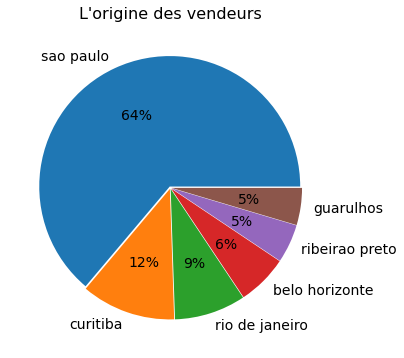

In [34]:
vendeur = sellers.seller_city.value_counts()[:6]
fig, ax = plt.subplots(figsize =(6, 6))
ax.pie(vendeur, labels = vendeur.index, autopct = '%.0f%%',explode=[0.01]*6,textprops={'fontsize': 14})
ax.set_title("L'origine des vendeurs",fontsize=16)

### 3.1.4 Données sur les clients

In [35]:
# Nombre de villes
Number_of_cities = df_final["customer_city"].nunique()
# Nombre d'Etats
Number_of_states = df_final["customer_state"].nunique()
# Nombre de consommateurs
Number_of_customers = df_final["customer_unique_id"].nunique()

print("Le nombre de villes est : {}".format(Number_of_cities))
print("Le nombre d'états est : {}".format(Number_of_states))
print("Le nombre de clients est : {}".format(Number_of_customers))

Le nombre de villes est : 4093
Le nombre d'états est : 27
Le nombre de clients est : 93404


Text(0.5, 1.0, "L'origine des clients")

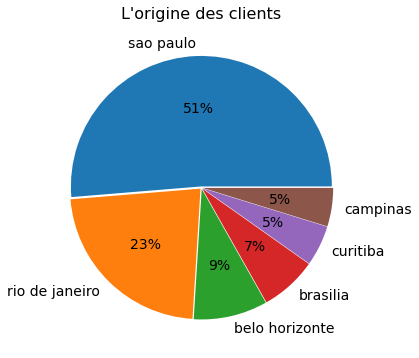

In [36]:
cities_cust = customers.customer_city.value_counts()[:6]
fig, ax = plt.subplots(figsize =(6, 6))
ax.pie(cities_cust, labels = cities_cust.index, autopct = '%.0f%%',explode=[0.01]*6,textprops={'fontsize': 14})
ax.set_title("L'origine des clients",fontsize=16)

### 3.1.5 Données sur les catégories de produits

In [37]:
print("Le nombre de catégories est de : {}"
      .format(product_category["product_category_name_english"].nunique()))

Le nombre de catégories est de : 71


### 3.1.6 Evaluation des produit pas les clients

In [38]:
# Conversion des données dates en datetime
review_answer_timestamp = pd.to_datetime(order_reviews["review_answer_timestamp"])
review_creation_date = pd.to_datetime(order_reviews["review_creation_date"])
# Délai d'évaluation des produits
review_answer = review_answer_timestamp - review_creation_date
# Converti en secondes
review_answer = review_answer.dt.total_seconds()/(3600*24)
order_reviews["Delay_to_answer"] = review_answer

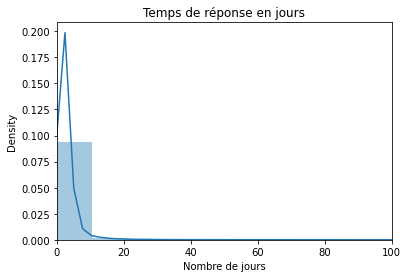

In [39]:
# Histogramme du délai d'évaluation des produits
sns.distplot(review_answer, label="Answer Time")
plt.xlim([0, 100])
plt.xlabel("Nombre de jours")
plt.title("Temps de réponse en jours")
plt.show()

### 3.1.7 Sur les produits

In [40]:
# Nombre de catégories
print("Le nombre de catégories est : {}"
      .format(products["product_category_name"].nunique()))

Le nombre de catégories est : 73


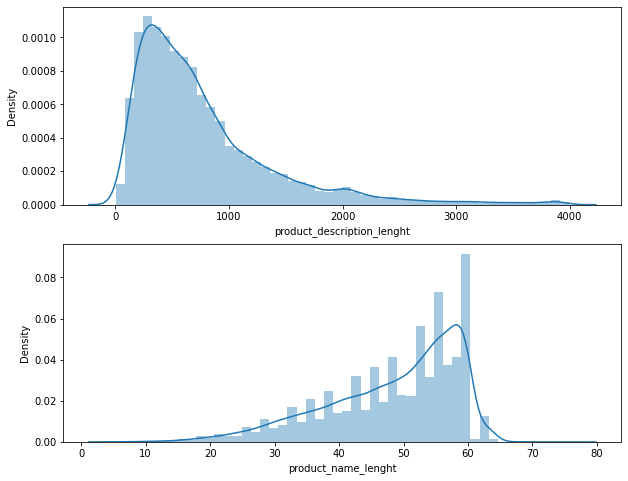

In [41]:
# Longueur de la description des produits
descr_nnull = products[~products["product_description_lenght"].isna()]
fig = plt.figure(1, figsize=(10, 8))
ax1 = fig.add_subplot(211)
sns.distplot(descr_nnull["product_description_lenght"], ax=ax1)
# Longueur du nom du produit
ax2 = fig.add_subplot(212)
sns.distplot(descr_nnull["product_name_lenght"], ax=ax2)

plt.show()

### 3.1.8 Sur les achats

In [42]:
achat_1 = df_final.groupby("customer_unique_id").filter(lambda x: len(x) == 1)
print("La base de données contient {} clients qui ont procédé à 1 achat".format(achat_1.customer_unique_id.unique().shape[0]))
nombre_achat_1 = achat_1.customer_unique_id.unique().shape[0]

La base de données contient 90597 clients qui ont procédé à 1 achat


In [43]:
achat_2 = df_final.groupby("customer_unique_id").filter(lambda x: len(x) > 1)
print("La base de données contient {} clients qui ont procédé à au moins 2 achats".format(achat_2.customer_unique_id.unique().shape[0]))
nombre_achat_2 = achat_2.customer_unique_id.unique().shape[0]

La base de données contient 2807 clients qui ont procédé à au moins 2 achats


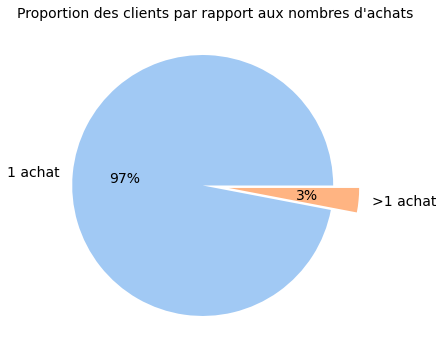

In [44]:
plt.figure(figsize=(6, 6))
data = [nombre_achat_1, nombre_achat_2]
labels = ["1 achat",'>1 achat']

colors = sns.color_palette('pastel')

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', textprops={'fontsize': 14},pctdistance=0.6,explode=[0.1]*2)
plt.title("Proportion des clients par rapport aux nombres d'achats",fontsize=14)
plt.show()

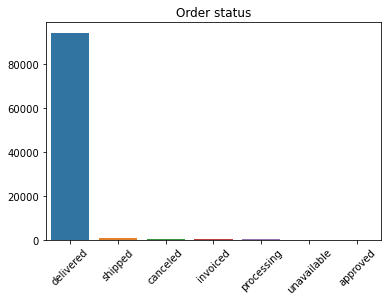

In [45]:
# Nombre de commandes par statuts d'achats
order_status = df_final.order_status.value_counts()
sns.barplot(x=order_status.index, y=order_status.values)
plt.title("Order status")
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Le nombre total de produits achetés par chaque client')

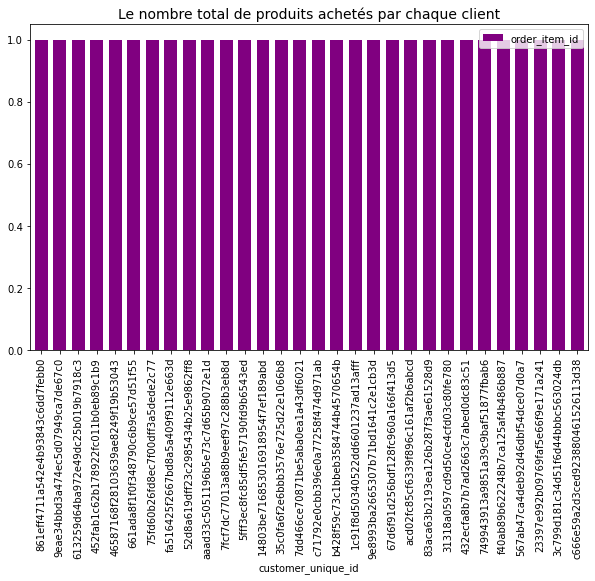

In [46]:
#Nombre total de produits achetés par clients
ax = df_final[:30].sort_values(by="order_item_id",ascending=False).plot.bar(x="customer_unique_id", y="order_item_id",figsize=(10,6),color="purple",width=0.7)
ax.set_title("Le nombre total de produits achetés par chaque client", fontsize=14)

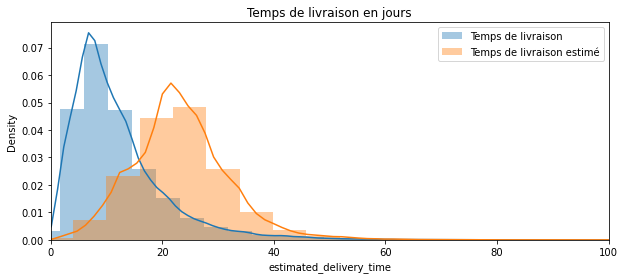

In [47]:
# Conversion des données dates en datetime
orders['order_approved_at'] = pd.to_datetime(
    orders['order_approved_at'])
orders['order_estimated_delivery_date'] = pd.to_datetime(
    orders['order_estimated_delivery_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(
    orders['order_delivered_customer_date'])

# Calculate differences in hours
orders['delivery_time'] = orders['order_delivered_customer_date'] \
                          - orders['order_approved_at']
orders['delivery_time'] = orders['delivery_time'] \
                          .dt.total_seconds() / 86400

orders['estimated_delivery_time'] = orders['order_estimated_delivery_date'] \
                                    - orders['order_approved_at']
orders['estimated_delivery_time'] = orders['estimated_delivery_time'] \
                                    .dt.total_seconds() / 86400

# Delivery estimated time and actual delivery time
plt.figure(figsize=(10, 4))
plt.title("Temps de livraison en jours")
sns.distplot(orders['delivery_time'].dropna(), label='Temps de livraison')
sns.distplot(orders['estimated_delivery_time']
             .dropna(), label='Temps de livraison estimé')
plt.legend()
plt.xlim([0, 100])
plt.show()
# Calcul la différence de temps entre
# le délai réel de livraison et le délai estimé
orders['diff_time_delivery'] = orders['delivery_time'] \
                               - orders['estimated_delivery_time']

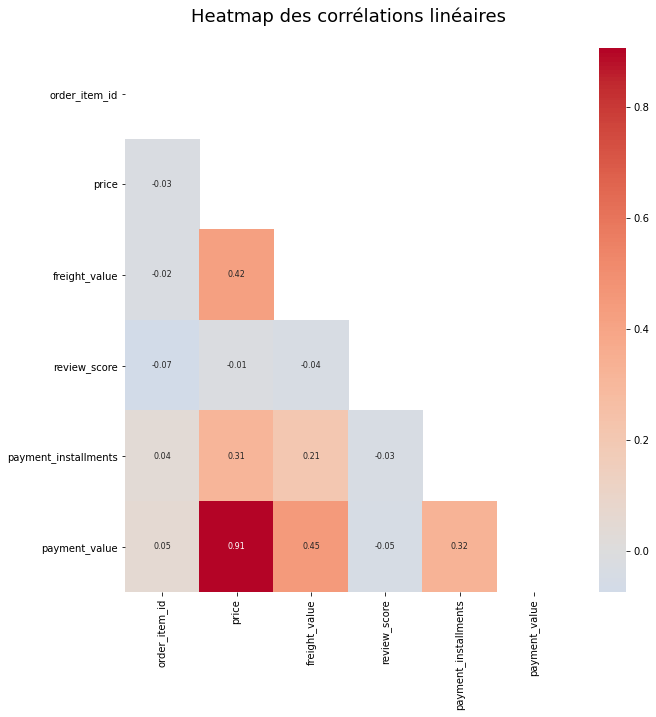

In [48]:
# Cross corrélation entre les variables

#matrice de corrélation 
corr = df_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize = 18)
plt.show()

# 4. Segmentation RFM <a class="anchor" id="partie4"></a>

#### Dans ce projet, nous allons utilser la segmentation RFM. RMF est un acronyme pour Recence, Fréquence et Montant.

- **Récence** indique la date du dernier achat. Il s'agit du nombre de jours depuis la dernière commande d'un client.
- **Fréquence** est le nombre d'achat sur une période déterminé. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevé et plus le client est engagé.
- **Montant** est la somme totale qu'un client dépense sur une période donnée

### 4.1 Création de la fonction permettant de calculer la RFM <a class="anchor" id="partie4_1"></a>
#### Nous ajouterons dans le calcul les avis 

In [46]:
df_final

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_item_id,order_status,product_id,seller_id,seller_city,seller_state,order_approved_at,price,freight_value,product_category_name,review_id,review_score,payment_type,payment_installments,payment_value,seller_city
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-05-16 15:22:12,124.99,21.88,moveis_escritorio,88b8b52d46df026a9d1ad2136a59b30b,4,credit_card,2,146.87,itaquaquecetuba
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-11-10 00:47:48,112.99,24.90,moveis_escritorio,7fc63200f12eebb5f387856afdd63db8,1,credit_card,1,275.79,itaquaquecetuba
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-05-08 22:22:56,124.99,15.62,moveis_escritorio,251191809e37c1cffc16865947c18a4d,3,credit_card,7,140.61,itaquaquecetuba
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,mage,RJ,2e604b3614664aa66867856dba7e61b7,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2018-02-04 22:29:19,106.99,30.59,moveis_escritorio,f7123bac5b91a0e2e38d8b41fd1206f4,4,credit_card,10,137.58,itaquaquecetuba
5,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,angelina,SC,574fe1739f65af76badd0999db300b4f,1,delivered,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,2017-03-23 15:25:11,126.99,15.06,moveis_escritorio,1496c2a9c41a846ba946a98a09879660,4,credit_card,5,142.05,itaquaquecetuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117323,d21101a81657215bf9d86ccc3da340a1,9ba58a98da1d0abf0bd1e422e06c9051,sao manuel,SP,d35703faec55cda0ceeb4f50a4d584ae,1,canceled,4444290d1f0ec9579d5b21dc589251c0,4ce6e5f6c52515177e18c1c9361d8677,sao bernardo do campo,SP,2018-07-16 22:20:45,226.60,25.67,automotivo,2bb20c7f19a9aa625bd8e6ba9f000f27,3,credit_card,5,252.27,sao bernardo do campo
117324,eda10d7eb51a675d000956fa1aabc7dd,5c22dbb9d8b5385953f2f1e6d9d115a7,jordania,MG,b494f624c631105b24fe497277085909,1,delivered,a2fce4213a6ac271129618259a334261,9140ef75cc8211c4035935e80e567204,maringa,PR,2018-08-02 18:50:15,49.90,22.28,pet_shop,709ee020ff826ee5289d7dd5d6911d0c,5,credit_card,3,72.18,maringa
117325,f0f671d4034e98cdf20f0c452d6db02b,6532316a8c1a7c7a569482db073530bb,guarulhos,SP,f73b31435ce6dec43df056154c39a1ce,1,shipped,5ece1e51ece4648de249ec6e9d007fd6,da4d149c0ddbac90557103ac0a0ec356,sbc,SP,2018-08-20 15:35:42,730.00,45.98,casa_construcao,274e38de8990f74fc03894fa488b5cd5,3,credit_card,10,775.98,sbc
117326,b90b857a277b080d8078332b3636ab58,7f5f43a9394964ac51bc5d1e0204ead4,uruacu,GO,d76fe905f4588ad69ab3b36527bb267d,1,delivered,d6e7ac236e583af1e1543d8068c91676,377bc18334c78dd2f1535ef22a3ad225,sao jose dos pinhais,PR,2018-08-18 21:10:13,135.98,88.46,ferramentas_jardim,6010e1ba95a9e19dc10a7b761932cf98,5,credit_card,6,224.44,sao jose dos pinhais


In [49]:
# Fonction permettant de calculer la RMF
def calculateRFM(data, period, today):
    """
    Calcul des valeurs R, F et M et Avis

    Paramètres:
    - data(pd.DataFrame): doit contenir les colonnes 'payment_value',
    'purchase_time' et 'customer_id' et cusomer_unique_id
    - period(int): Nombre de jours
    - today(dt.datetime): date de fin de période

    Return:
    rfm(pd.DataFrame): retourne un pd.DataFrame avec les variables Récence,
    Fréquence , Montant et les avis
    """
    # Nombre de jours passés entre aujourd'hui
    # et la dernière commande de chaque utilisateur
    data["order_approved_at"] = pd.\
    to_datetime(data["order_approved_at"])

    data = data.groupby('customer_unique_id').\
            agg({"order_approved_at": lambda x: (today - x.max()).days,
                 "order_id": lambda x: x.nunique(),
                 "price": lambda x: sum(x),
                 "review_score": lambda x: round(x.mean())}).reset_index()

    data['order_approved_at'] = data['order_approved_at'].astype(int)
    data.rename(columns={'order_approved_at': 'Récence',
                         'order_id': 'Fréquence',
                         'price': 'Montant',     
                         'review_score': 'Avis'}, inplace=True)
   
    return data

In [50]:
#La date d'achat la plus ancienne 
ancien = df_final["order_approved_at"].min()
ancien

'2016-10-04 09:43:32'

In [51]:
# La date d'achat la plus recente 
recent = df_final["order_approved_at"].max()
recent

'2018-09-03 17:40:06'

In [52]:
# Nous prendrons pour jours d'aujourd'hui le dernier d'achat
today = pd.to_datetime(recent)
today

Timestamp('2018-09-03 17:40:06')

In [53]:
periode=100000 # L'idée est d'être sûr qu'on a pris toutes les jours couvrant les achats
rmftable= calculateRFM(df_final, periode, today)

In [101]:
rmftable = rmftable.sort_values(by="Fréquence",ascending=False)

In [54]:
rmftable

,customer_unique_id,Récence,Fréquence,Montant,Avis
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,5
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4
2,0000f46a3911fa3c0805444483337064,541,1,69.00,3
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,4
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,5
...,...,...,...,...,...
93399,fffcf5a5ff07b0908bd4e2dbc735a684,451,1,680.00,5
93400,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89,4
93401,ffff371b4d645b6ecea244b27531430a,573,1,89.90,5
93402,ffff5962728ec6157033ef9805bacc48,124,1,115.00,5


### 4.2 Analyse exploratoire sur la RFM <a class="anchor" id="partie4_2"></a>

{'whiskers': [<matplotlib.lines.Line2D at 0x1f08e30bb50>,
 'caps': [<matplotlib.lines.Line2D at 0x1f08e317250>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f08e30b7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f08e317910>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f08e317c10>],
 'means': []}

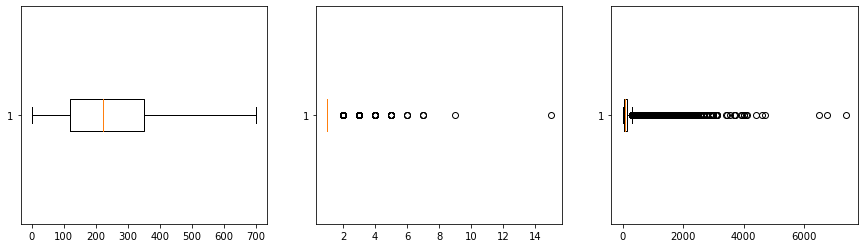

In [55]:
# Boites à moustaches
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.boxplot(rmftable["Récence"], vert=False)

ax = fig.add_subplot(132)
ax.boxplot(rmftable["Fréquence"], vert=False)

ax = fig.add_subplot(133)
ax.boxplot(rmftable["Montant"], vert=False)

- Nous allons afficher pour 50 clients, le nombre total de jours après dernier achat, le nombre total d'achat par client et le montant total d'achat

Text(0.5, 1.0, "Le montant total payé par chaque client pour l'ensemble des achats effectués")

<Figure size 1080x288 with 0 Axes>

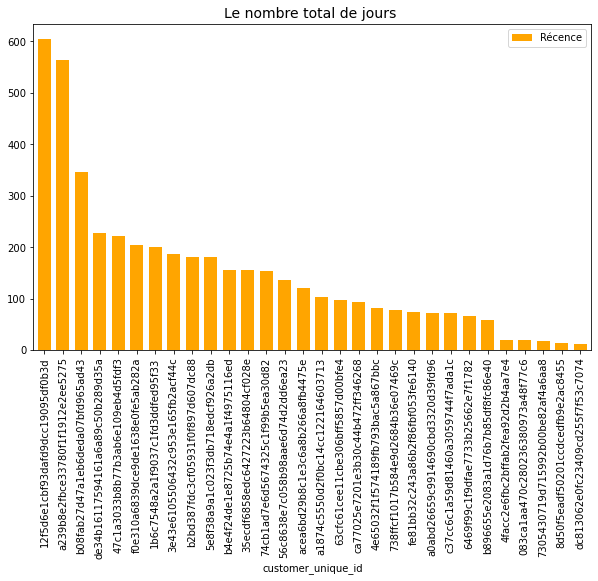

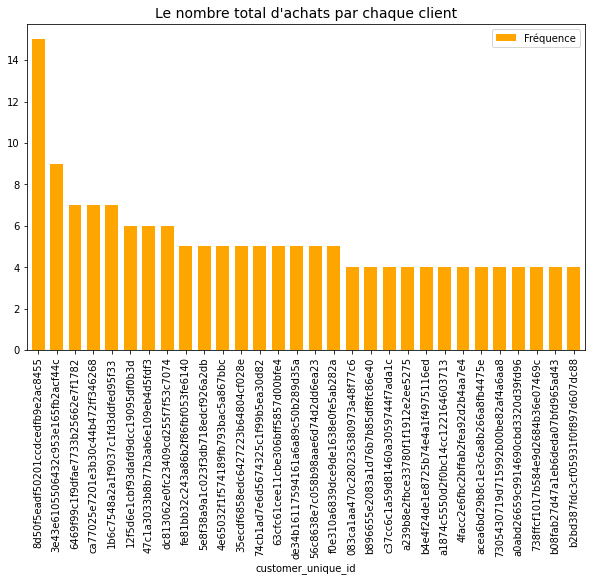

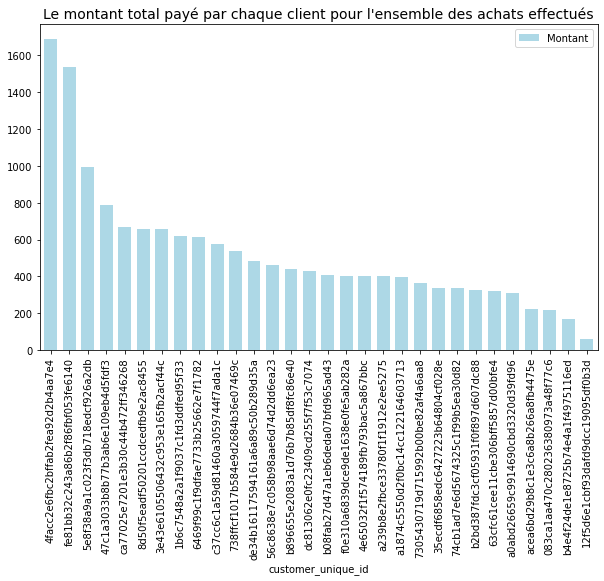

In [106]:
# Affichage de la Récence, de la Fréquence et du montant total des achats par client
fig = plt.figure(figsize=(15, 4))

# Nombre total de jours par clients après dernier achat
ax = rmftable[:50].sort_values(by="Récence",ascending=False).plot.bar(x="customer_unique_id", y="Récence",figsize=(10,6),color="orange",width=0.7)
ax.set_title("Le nombre total de jours ", fontsize=14)

# Nombre total d'achats par clients
ax = rmftable[:50].sort_values(by="Fréquence",ascending=False).plot.bar(x="customer_unique_id", y="Fréquence",figsize=(10,6),color="orange",width=0.7)
ax.set_title("Le nombre total d'achats par chaque client", fontsize=14)

#Somme totale depensée par clients
ax = rmftable[:50].sort_values(by="Montant",ascending=False).plot.bar(x="customer_unique_id",y="Montant",figsize=(10,6),color="lightblue",width=0.7)
ax.set_title("Le montant total payé par chaque client pour l'ensemble des achats effectués", fontsize=14)

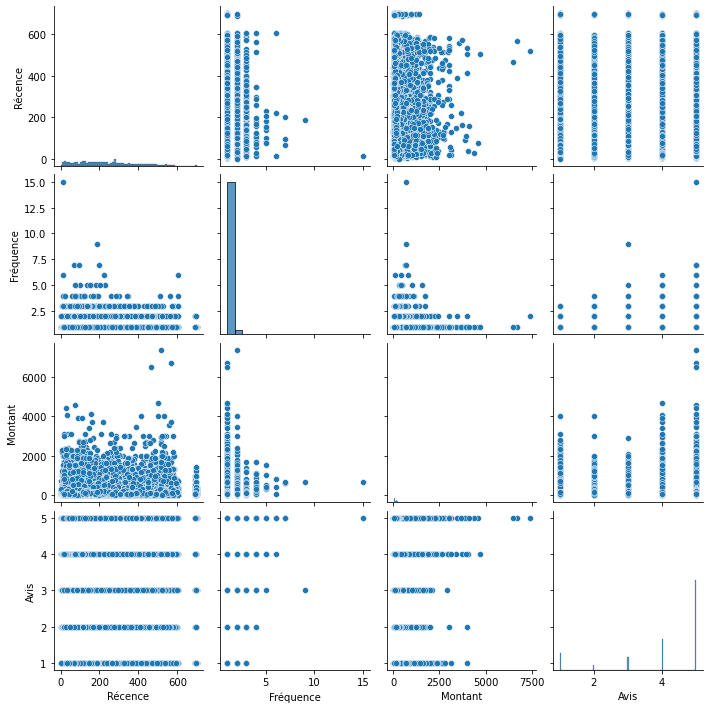

In [57]:
#Pariplot
sns.pairplot(rmftable)

In [58]:
# Cross corrélation entre les différentes variables

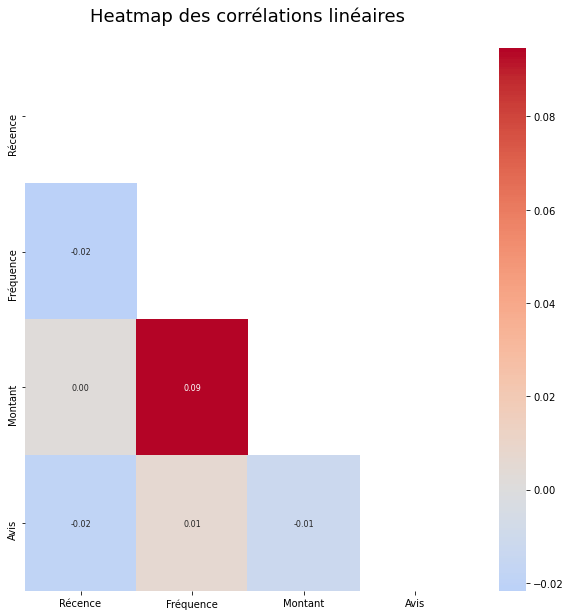

In [59]:
#matrice de corrélation 
corr = rmftable.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontsize = 18)
plt.show()

In [60]:
# En registrement de nos données nettoyées en csv
rmftable.to_csv('data_rmf.csv', encoding='utf-8')